In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import community.community_louvain as community_louvain
from wordcloud import WordCloud

sns.set_style('darkgrid')
pd.options.display.max_colwidth = 500

### Graph

In [2]:
# loading JSON file with saved similarities
with open('data/similarity_dict.json') as json_file:
    data = json.load(json_file)
# exemplary records from the dictionary in a form ('userId1|userId2' : similarity)
random.sample(list(data.items()), 5)

[('A3VEUJHN4DPICU|AN5N61OZ2PK5H', 0.03626943005181347),
 ('A25F57YK2GN6ST|A35L81CBN2Z8C0', 0.03626943005181347),
 ('A1AYC9H2IDHJHO|A30QS4SIAONE9L', 0.03626943005181347),
 ('AJ1CE24O54TFM|AJGESVGXIAEPY', 0.03626943005181347),
 ('A2YPGQH2UGGTM2|A3RCW2IIWQ0UQ1', 0.03626943005181347)]

In [3]:
# defining edges based on dictionary keys
edges = [k.split('|') for k in data.keys()]
# defining edge weights based on dictionary values
weights = list(data.values())
# initiating the graph
G = nx.Graph()
for e, w in zip(edges, weights):
    # adding nodes and edges if corresponding similarity is higher than threshold
    if w >= 0.04:
        G.add_weighted_edges_from([(e[0], e[1], w)], weight='similarity')

In [4]:
# reading data corresponding to the dictionary
sample = pd.read_csv('data/sample_no_agg.csv')

In [5]:
# adding spaces as separator for aggregation below (pasting strings together)
sample['Clean_text'] = sample['Clean_text'] + ' ' 
# aggregating reviews per user
sample_agg = sample[['UserId', 'Clean_text']].groupby('UserId').apply('sum')

### Community detection

In [6]:
# extracting biggest connected component from the graph
subnodes = sorted(nx.connected_components(G), key=len, reverse=True)[0]
# creating a subgraph based on the nodes within the component
Gcc = G.subgraph(subnodes)
G = nx.to_undirected(Gcc)

# applying algorithm for community detection
partition = community_louvain.best_partition(G, random_state=123, weight='similarity')

In [7]:
print('Number of nodes: ', G.number_of_nodes())
print('Number of edges: ', G.number_of_edges())

Number of nodes:  21389
Number of edges:  284308


In [8]:
# adding partition assignment to the users data
sample_agg_with_partition = (
    sample_agg
    .join(pd.DataFrame([partition]).T, how='inner')
    .rename(columns={0:'Partition'})
)

In [9]:
# count number of communities by adding 1 to the highest community number (enumeration starting with 0)
nr_of_communities = max(partition.items(), key=lambda x:x[1])[1] + 1
print(f'Number of communities: {nr_of_communities}')

# preprocess partition into a list of lists containing nodes belonging to comunities
partition_list = [None]*nr_of_communities
for i in range(nr_of_communities):
    partition_list[i] = [node for node in G.nodes if partition[node] == i]

# compute modularity
modularity = nx.community.modularity(G, partition_list)
print(f'Modularity for the best partition: {round(modularity, 2)}')

Number of communities: 10


Modularity for the best partition: 0.57


In [10]:
# aggregating reviews per partition
sample_partitioned = sample_agg_with_partition.groupby('Partition').sum()

In [11]:
# Printing communities sizes
print(f'Community sizes: {str([len(p) for p in partition_list])[1:-1]}')


Community sizes: 3243, 2577, 1969, 3764, 2717, 1643, 2034, 785, 2320, 337


### Word clouds

In [12]:
# tf-idf vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=20000, max_df=0.85)
vecs = vectorizer.fit_transform(sample_partitioned['Clean_text'])
feature_names = vectorizer.get_feature_names_out()
vecs_dense = vecs.todense().tolist()
df = pd.DataFrame(vecs_dense, columns=feature_names)

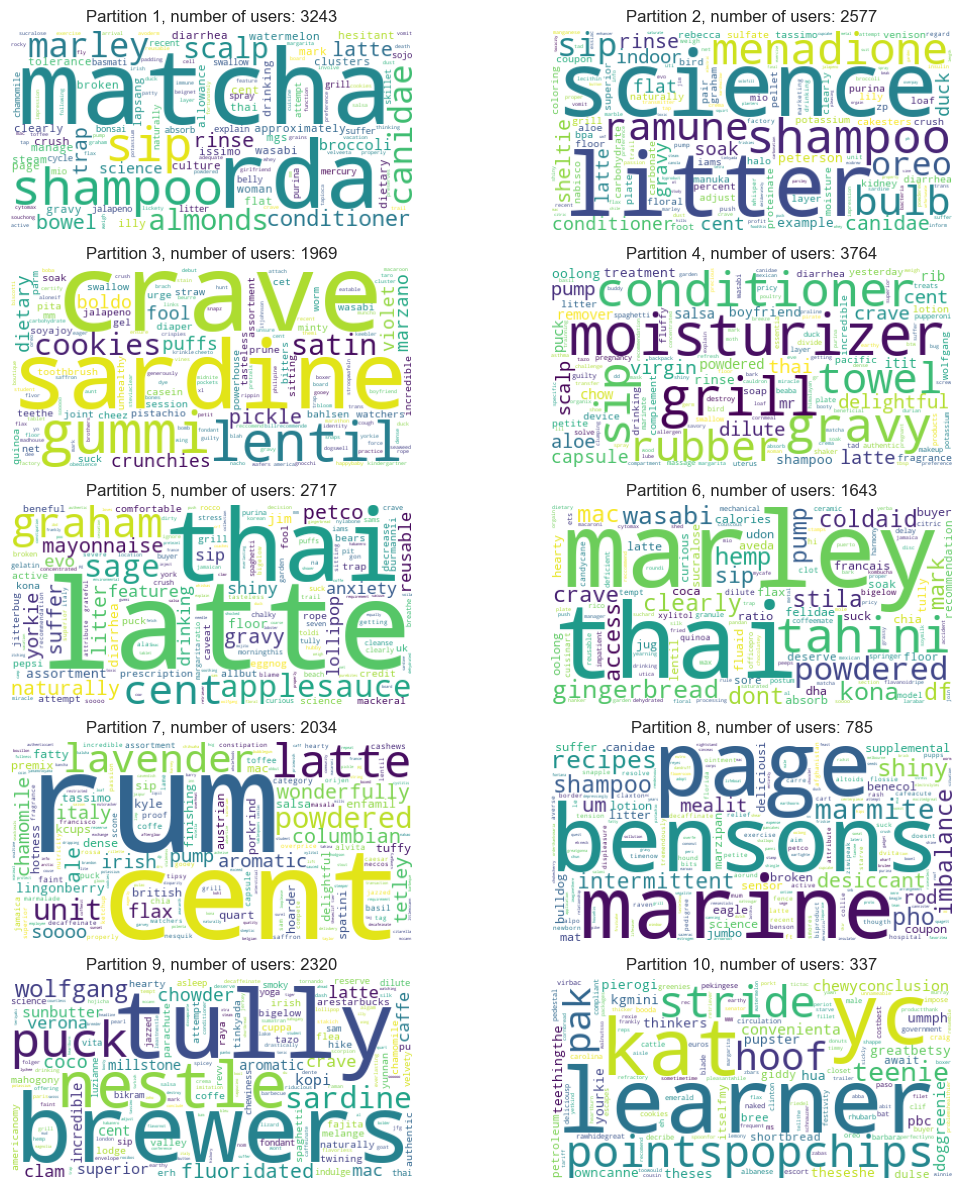

In [13]:
# creating wordclouds (one per partition)
fig, ax = plt.subplots(5,2,figsize=(12,12))
for i in list(df.index):
    Cloud = WordCloud(background_color="white", max_words=200).generate_from_frequencies(df.loc[i,:])
    ax[i//2, i%2].imshow(Cloud)
    ax[i//2, i%2].set_title(f'Partition {i+1}, number of users: {len(partition_list[i])}')
    ax[i//2, i%2].axis("off")
plt.tight_layout()
plt.show()

In [15]:
sample_agg = sample_agg.reset_index()

### Topic modelling

In [16]:
vectorizer_all = TfidfVectorizer(stop_words='english', max_features=20000, max_df=0.85)
vecs_all = vectorizer_all.fit_transform(sample_agg['Clean_text'])
feature_names_all = vectorizer_all.get_feature_names_out()

In [17]:
# Define the number of topics or components
num_components=3

for p in range(len(partition_list)):
    # Create LDA object
    model=LatentDirichletAllocation(n_components=num_components)
    # Fit and Transform SVD model on data
    lda_matrix = model.fit_transform(vecs_all[list(sample_agg[sample_agg.UserId.isin(partition_list[p])].index), :])
 
    # Get Components 
    lda_components=model.components_
    print(f'Partition {p+1}')
    # extract topics
    for index, component in enumerate(lda_components):
        zipped = zip(feature_names_all, component)
        top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:5]
        top_terms_list=list(dict(top_terms_key).keys())
        print("Topic "+str(index)+": ",top_terms_list)

Partition 1
Topic 0:  ['bisque', 'lobster', 'sumac', 'caper', 'barefoot']
Topic 1:  ['nt', 'like', 'taste', 'try', 'good']
Topic 2:  ['sheen', 'jolly', 'jf', 'recevie', 'correspond']
Partition 2
Topic 0:  ['sambar', 'zotz', 'plockys', 'decafe', 'raven']
Topic 1:  ['icicle', 'chorizo', 'jimmies', 'ing', 'autolyze']
Topic 2:  ['nt', 'taste', 'like', 'good', 'flavor']
Partition 3
Topic 0:  ['sardine', 'snail', 'refrigeration', 'powerade', 'medela']
Topic 1:  ['love', 'good', 'great', 'like', 'treat']
Topic 2:  ['refrie', 'lard', 'wing', 'pocky', 'soldier']
Partition 4
Topic 0:  ['love', 'taste', 'use', 'great', 'good']
Topic 1:  ['coffee', 'iced', 'bold', 'pod', 'cup']
Topic 2:  ['hairball', 'nip', 'saunier', 'explanation', 'alergie']
Partition 5
Topic 0:  ['biscotti', 'dirty', 'sensitivity', 'jive', 'grandfather']
Topic 1:  ['nt', 'like', 'love', 'taste', 'product']
Topic 2:  ['manner', 'bold', 'grey', 'earl', 'roast']
Partition 6
Topic 0:  ['dont', 'salsa', 'stamps', 'samu', 'endorser']

### Graph stats

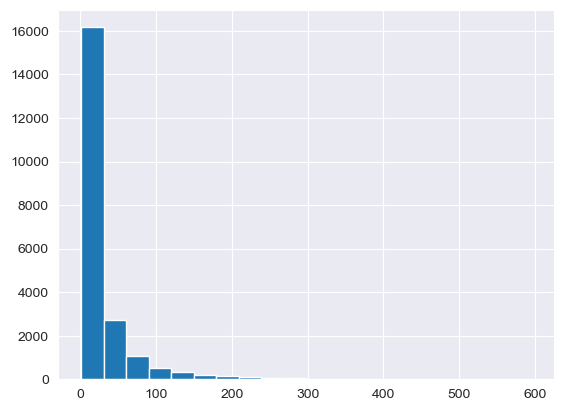

In [18]:
degrees = dict(G.degree)
d_values = list(degrees.values())
plt.hist(d_values, bins=20)
plt.show()

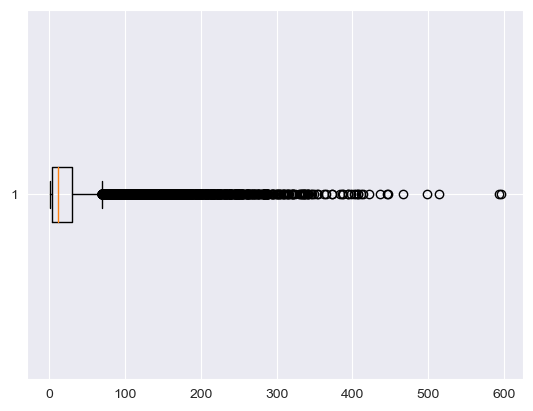

In [19]:
plt.boxplot(d_values, vert=False)
plt.show()

In [20]:
pd.Series(d_values).describe()

count    21389.000000
mean        26.584506
std         43.683911
min          1.000000
25%          4.000000
50%         11.000000
75%         30.000000
max        596.000000
dtype: float64

In [21]:
weights_list = list(nx.get_edge_attributes(G, 'similarity').values())
pd.Series(weights_list).describe()

count    284308.000000
mean          0.046328
std           0.007598
min           0.041667
25%           0.041667
50%           0.041667
75%           0.047120
max           0.162791
dtype: float64

In [22]:
# communities, wordcloudy dla dwoch najwiekszych uzywajac tfidf
# lub count ngramow?